<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit
from datetime import timedelta, datetime

In [3]:
ratio_mean_guess = 0.78
ratio_std_guess = 0.02

# Open DataFrame

In [4]:
upper_int = 100000
lower_int = 0

## Pulse Data

Open up all runs.

In [5]:
dfs = []
path = 'datafiles/jan_14_2019'
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        df = pd.read_csv(path+'/'+filename, sep=',', index_col=0).astype(float)
        df['ratio']=df['Integral 1200']/df['Integral 7400']
        df.index = pd.to_datetime(df.index,unit='s')-timedelta(hours=7)
        
        df = df[(df['ratio']<1) & (df['ratio']>0)] #should not have to do this
        df = df[(df['Integral 7400']<upper_int) & (df['Integral 7400']>lower_int)] #should not have to do this
        dfs.append(df)

dfs = sorted(dfs,key=lambda x:x.index[0]) #sort by initial time

Get beginning and end of each run. Need to subtract 1 hour because computer did not account for the time change.

In [6]:
begins = sorted([df.index.values[0]-np.timedelta64(1,'h') for df in dfs])
ends = sorted([df.index.values[-1]-np.timedelta64(1,'h') for df in dfs])

## Temperature Data

In [7]:
temps = []
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        temp = pd.read_csv(path+'/'+filename, skiprows=7, sep='\t')
        temp['Time'] = pd.to_datetime(temp['DATE']+'-'+temp['TIME'])
        temp.index = temp['Time']
        temp = temp[['TEMPERATURE', 'RELATIVE-HUMIDITY', 'DEW-POINT']]
        temps.append(temp)
temps = sorted(temps,key=lambda x:x.index[0]) #sort by initial time

# Preliminary Plot

Plot energy ratios.

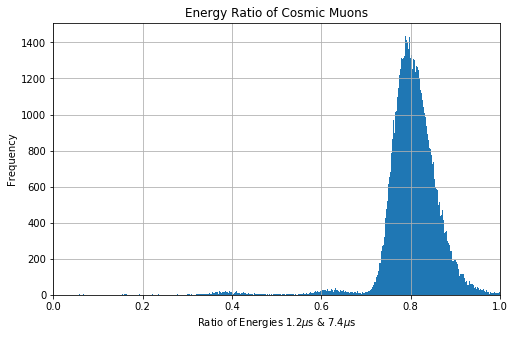

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

dfs[0]['ratio'].hist(bins=500, ax=ax)

ax.set_xlim(0,1)
ax.set_xlabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')
ax.set_ylabel('Frequency')
ax.set_title('Energy Ratio of Cosmic Muons')
plt.show()

Plot energy deposited.

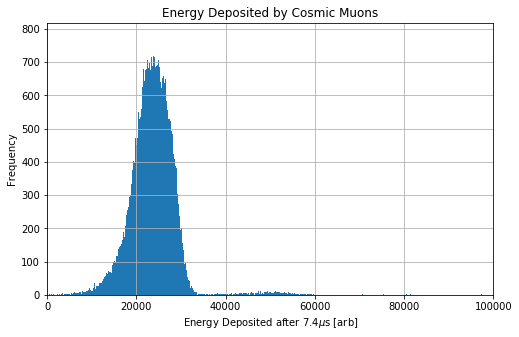

In [9]:
fig, ax = plt.subplots(figsize=(8,5))

dfs[0]['Integral 7400'].hist(bins=1000, ax=ax)
ax.set_xlim(0,100000)
ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Frequency')
ax.set_title('Energy Deposited by Cosmic Muons')

plt.show()

# Fitting Methods to Find the Mode

In [10]:
df = dfs[0]

Define the normal curve:

In [11]:
def norm(x, u, sig, amp):
    return amp*np.exp(-((x-u)**2)/(2*sig**2))

Fit the histogram data between 0.75 and 0.8.

In [12]:
mask = (df['ratio']>0.75) & (df['ratio']<0.825)

h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
x = x[:-1]

p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
popt, pcov = curve_fit(norm, x, h, p0=p0)
perr = np.sqrt(np.diag(pcov))

Initial Plot.

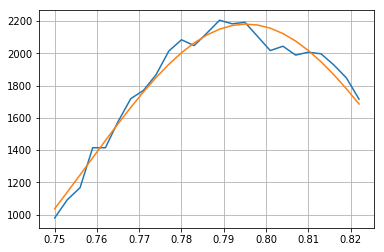

In [13]:
fig, ax = plt.subplots()

ax.plot(x,h)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

#ax.set_ylim(0, 400)
ax.grid()

Do plotting:

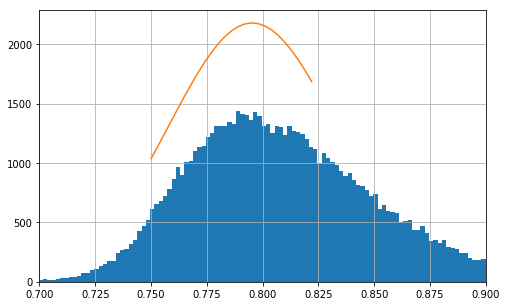

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

y= df['ratio'].hist(bins=500, ax=ax)
ax.plot(x,norm(x, popt[0], popt[1], popt[2]), label='Fit')

ax.set_xlim(0.7,0.9)
plt.show()

# Automation

In [15]:
def mode_ratio(df):
    mask = (df['ratio']>0.75) & (df['ratio']<0.825)

    h, x , _ = plt.hist(df['ratio'][mask], bins=25); plt.close()
    x = x[:-1]

    p0  = (ratio_mean_guess, ratio_std_guess, np.max(h))
    popt, pcov = curve_fit(norm, x, h, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    
    return popt[0], perr[0]

In [23]:
mode_ratio(dfs[0])

(0.7953259673823339, 0.000615282550263415)

In [25]:
asd = np.array([mode_ratio(dfs[i])[0] for i in range(20)])

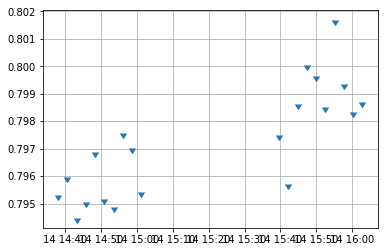

In [26]:
fig, ax = plt.subplots()

ax.plot(begins,asd, linestyle="none", marker=11)
ax.grid()

# 2D Histogram Stuff:

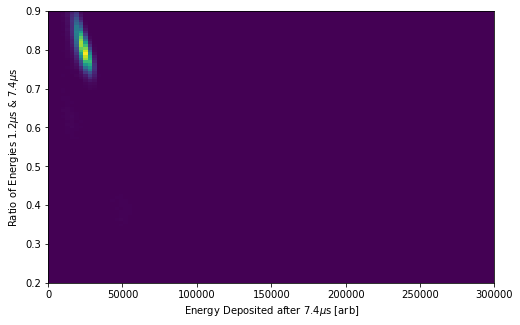

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.hist2d(df['Integral 7400'].values, df['ratio'].values,
          range=np.array([(0, 300000), (0.2, 0.9)]), bins=100)

ax.set_xlabel('Energy Deposited after 7.4$\mu$s [arb]')
ax.set_ylabel('Ratio of Energies 1.2$\mu$s & 7.4$\mu$s')

plt.show()

# Plot Some Temperature Stuff

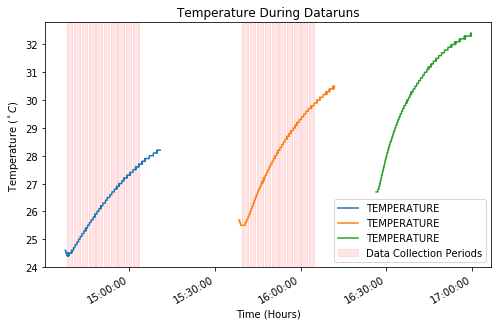

In [20]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(temps[0]['TEMPERATURE'])
ax.plot(temps[1]['TEMPERATURE'])
ax.plot(temps[2]['TEMPERATURE'])

(begin,end) = (begins[0], ends[0])
ax.axvspan(begin, end, alpha=0.1, color='red', label='Data Collection Periods') # get the label in there
[ax.axvspan(begin, end, alpha=0.1, color='red') for begin,end in zip(begins[1:20], ends[1:20])] #get the rest

xfmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()

ax.set_title('Temperature During Dataruns')
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Time (Hours)')
ax.legend()

plt.show()